# Relay Races and Revolving Doors

This is one of the Jupyter notebooks I used in my preparation of *Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions*.

The book is scheduled to be published by University of Chicago Press in 2023.
If you would like to get infrequent email announcements about the book, please
[sign up for my mailing list](http://eepurl.com/h0nfbX).

Before you read these notebooks, please keep in mind:

* There is some explanatory text in the notebooks, but some of the examples will not make sense until you have read the corresponding chapter in the book.

* While preparing these notebooks, I made some changes to improve the readability of the code. There might be small differences between what appears in the book and what you get when you run the code.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/notebooks/inspection.ipynb).

I gave a talk related to this chapter at PyData NYC 2019. You can [watch the video here](https://www.youtube.com/watch?v=cXWTHfvycyM).

In [1]:
# Install empirical dist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# download utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py")

When you run 209 miles, you have a lot of time to think. In 2010, I was
a member of a 12-person team that ran a 209-mile relay race in New Hampshire.

Long-distance relay races are an unusual format, and this was the first
(and last!) time I participated in one. I ran the third leg, so when I
joined the race, it had been going for a few hours and runners were
spread out over several miles of the course.

After I ran a few miles, I noticed something unusual:

* There were more fast runners in the race than I expected. Several times I was overtaken by runners much faster than me.

* There were also more slow runners than I expected. When I passed other runners, I was often much faster than them.

At first I thought this pattern might reflect the kind of people who
sign up for a 209-mile race. Maybe, for some reason, this format appeals
primarily to runners who are much faster than average or much slower,
and not as much to middle-of-the-pack runners like me.

After the race, with more oxygen available to my brain, I realized that
this explanation is wrong. To my embarrassment, I was fooled by a common
statistical error, one that I teach students in my classes!

The error is called length-biased sampling, and its effect is called the
inspection paradox. If you have not heard of it, this chapter will
change your life, because once you learn about the inspection paradox,
you see it everywhere.

To explain it, I'll start with simple examples and we will work our way
up. Some of the examples are fun, but some are more serious. For
example, length-biased sampling shows up in the criminal justice system
and distorts our perception of prison sentences and the risk of repeat
offenders.

But it's not all bad news; if you are aware of the inspection paradox,
sometimes you can use it to measure indirectly quantities that would be
hard or impossible to measure directly. As an example, I'll explain a
clever system used during the COVID pandemic to track infections and
identify superspreaders.

But let's start with class sizes.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed so we get the same results every time
np.random.seed(17)

## Class Size

The class sizes in this section come from data reported by
Purdue University for undergraduate class sizes in the 2013--14 academic
year. 

[The data was originally posted here](https://www.purdue.edu/datadigest/2013-14/InstrStuLIfe/DistUGClasses.html)

[Now archived here](https://web.archive.org/web/20160415011613/https://www.purdue.edu/datadigest/2013-14/InstrStuLIfe/DistUGClasses.html)

It typed in the number of classes in the row labeled "Total all classes".

In [4]:
sizes = [(1, 1), (2, 9), (10, 19), (20, 29), (30, 39), (40, 49), (50, 99), (100, 300)]

counts = [138, 635, 1788, 1979, 796, 354, 487, 333]

Since the class sizes are specified in ranges, I used the following function to generate uniform random samples within each range.

In [5]:
def generate_sample(sizes, counts):
    """Generate a sample from a distribution.

    sizes: sequence of (low, high) pairs
    counts: sequence of integers

    returns: NumPy array
    """
    t = []
    for (low, high), count in zip(sizes, counts):
        print(low, high, count)
        sample = np.random.randint(low, high + 1, count)
        t.extend(sample)
    return np.array(t)

In [6]:
unbiased = generate_sample(sizes, counts)

1 1 138
2 9 635
10 19 1788
20 29 1979
30 39 796
40 49 354
50 99 487
100 300 333


The following function takes a sample and generates a new random sample, using the given weights.

In [7]:
def resample_weighted(sample, weights):
    """Generate a biased sample.

    sample: NumPy array
    weights: NumPy array

    returns: NumPy array
    """
    n = len(sample)
    p = weights / np.sum(weights)
    return np.random.choice(sample, n, p=p)

In [8]:
biased = resample_weighted(unbiased, unbiased)

Here's the distribution of class sizes as given in the report.

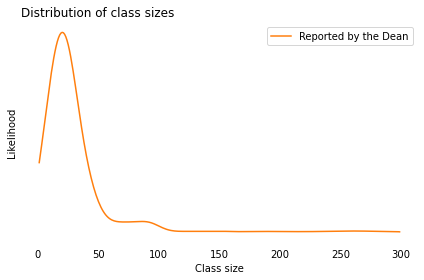

In [9]:
from utils import decorate, kdeplot

xs = np.arange(1, 300)
kdeplot(unbiased, xs, "Reported by the Dean", color="C1")

decorate(xlabel="Class size", title="Distribution of class sizes")

The upper bound in this figure, 300, is just my guess. The original data
indicates how many classes are bigger than 100, but it doesn't say how
much bigger. For this example, though, we don't have to be too precise.

Now here's what the distribution would look like if we sampled students.

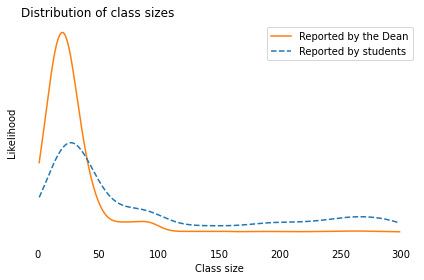

In [10]:
xs = np.arange(1, 300)
kdeplot(unbiased, xs, "Reported by the Dean", color="C1")
kdeplot(biased, xs, "Reported by students", ls="--")

decorate(xlabel="Class size", title="Distribution of class sizes")

In [11]:
np.mean(unbiased)

34.611827956989245

In [12]:
np.mean(biased)

92.59815668202765

## Unbiasing the Data

Now suppose we collect a biased sample of 500 class sizes and apply the inverse weights to estimate the unbiased distribution.

In [13]:
sample = np.random.choice(biased, 500)

In [14]:
reweighted = resample_weighted(sample, 1 / sample)

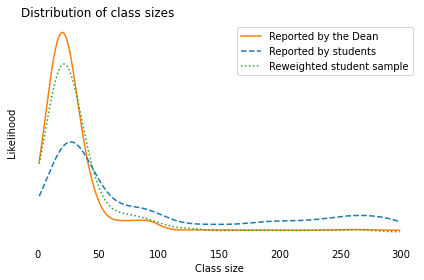

In [15]:
xs = np.arange(1, 300)
kdeplot(unbiased, xs, "Reported by the Dean", color="C1")
kdeplot(biased, xs, "Reported by students", ls="--")
kdeplot(reweighted, xs, "Reweighted student sample", color="C2", ls=":")

decorate(xlabel="Class size", title="Distribution of class sizes")

If the estimate were perfect, the solid and dotted lines would be
identical. But with a limited sample size, we underestimate the number
of small classes by a little and overestimate the number of classes with
50-80 students. Nevertheless, it works pretty well.

This strategy works in other cases where the actual distribution is not
available, deliberately or not. If we can collect a good quality sample
from the biased distribution, we can approximate the actual distribution
by drawing a sample from the biased data. This process is an example of
weighted resampling. It's "weighted" in the sense
that some items are given more weight than others, that is, more
probability of being sampled. And it's called "resampling" because we're
drawing a random sample from something that is itself a random sample.

## Where's My Train?

I collected the following data from the Red Line, which is a
subway line in Boston, Massachusetts. The MBTA, which operates the Red
Line, provides a real-time data service, which I used to record the
arrival times for 70 trains between 4pm and 5pm over several days.
I don't remember when, but I think it was in 2010.

In [16]:
unbiased = [
    428.0,
    705.0,
    407.0,
    465.0,
    433.0,
    425.0,
    204.0,
    506.0,
    143.0,
    351.0,
    450.0,
    598.0,
    464.0,
    749.0,
    341.0,
    586.0,
    754.0,
    256.0,
    378.0,
    435.0,
    176.0,
    405.0,
    360.0,
    519.0,
    648.0,
    374.0,
    483.0,
    537.0,
    578.0,
    534.0,
    577.0,
    619.0,
    538.0,
    331.0,
    186.0,
    629.0,
    193.0,
    360.0,
    660.0,
    484.0,
    512.0,
    315.0,
    457.0,
    404.0,
    740.0,
    388.0,
    357.0,
    485.0,
    567.0,
    160.0,
    428.0,
    387.0,
    901.0,
    187.0,
    622.0,
    616.0,
    585.0,
    474.0,
    442.0,
    499.0,
    437.0,
    620.0,
    351.0,
    286.0,
    373.0,
    232.0,
    393.0,
    745.0,
    636.0,
    758.0,
]

In [17]:
unbiased = np.array(unbiased) / 60

In [18]:
biased = resample_weighted(unbiased, unbiased)

Here's the unbiased distribution.

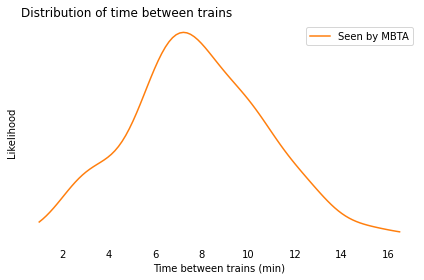

In [19]:
xs = np.linspace(1, 16.5, 101)
kdeplot(unbiased, xs, "Seen by MBTA", color="C1")

decorate(
    xlabel="Time between trains (min)", title="Distribution of time between trains"
)

And here's the biased distribution as seen by passengers.

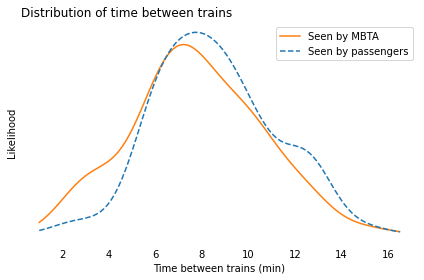

In [20]:
xs = np.linspace(1, 16.5, 101)
kdeplot(unbiased, xs, "Seen by MBTA", color="C1")
kdeplot(biased, xs, "Seen by passengers", ls="--")

decorate(
    xlabel="Time between trains (min)", title="Distribution of time between trains"
)

In [21]:
np.mean(biased), np.mean(unbiased)

(8.570714285714285, 7.7680952380952375)

In [22]:
(np.mean(biased) - np.mean(unbiased)) / np.mean(unbiased) * 100

10.332250352479615

In the actual distribution, the average time between trains is 7.8
minutes; in the biased distribution, as seen by a random passenger, it
is 9.2 minutes, about 20% longer.

## Are you popular? Hint: no.

To demonstrate the friendship paradox, I used data from a sample of about 4000
Facebook users from the [Stanford Network Analysis Project (SNAP)](http://snap.stanford.edu/).

In [23]:
download("https://snap.stanford.edu/data/facebook_combined.txt.gz")

The following function reads the Facebook data and builds a NetworkX graph.

In [24]:
import networkx as nx


def read_graph(filename, **options):
    """Read a graph from a file.

    filename: string

    return: Graph
    """
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int, **options)
    G.add_edges_from(array)
    return G

In [25]:
fb = read_graph("facebook_combined.txt.gz")
n = len(fb)
m = len(fb.edges())
n, m

(4039, 88234)

In [26]:
unbiased = [fb.degree(node) for node in fb]
len(unbiased)

4039

In [27]:
np.max(unbiased)

1045

In [28]:
biased = resample_weighted(unbiased, unbiased)

In [29]:
high = 250

Here's the unbiased distribution.

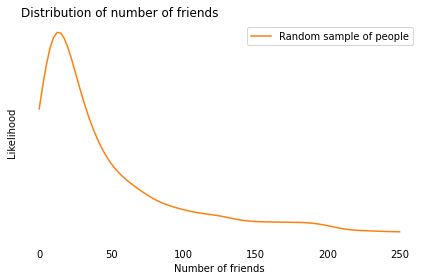

In [30]:
xs = np.linspace(0, high, 101)
kdeplot(unbiased, xs, "Random sample of people", color="C1")

decorate(
    xlabel="Number of friends",
    title="Distribution of number of friends",
)

And here's the biased distribution.
Compared to the unbiased distribution, people with more than 50 friends are
overrepresented; people with fewer friends are underrepresented.

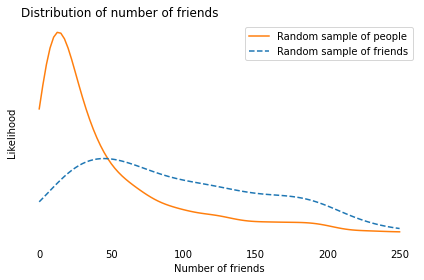

In [31]:
xs = np.linspace(0, high, 101)
kdeplot(unbiased, xs, "Random sample of people", color="C1")
kdeplot(biased, xs, "Random sample of friends", ls="--")

decorate(
    xlabel="Number of friends",
    title="Distribution of number of friends",
)

The difference between the distributions is substantial: in the unbiased
sample, the average user has 44 friends; in the biased sample, the
average friend has 104, more than twice as many. And if you are a random
person in this sample, the probability that your friend is more popular
than you is about 76%.

If you are a bottlenose dolphin in Doubtful Sound, New Zealand, you interact regularly with between 1 and 12 other dolphins, according to the researchers who mapped your social network.
If I choose one of your "friends" at random and compare them to you, the probability is about 65% that your friend has more friends than you.

The dolphin data is from [The Network Data Repository](https://networkrepository.com/soc_dolphins.php).

In [32]:
import os

download("http://nrvis.com/download/data/soc/soc-dolphins.zip")

if not exists('soc-dolphins.mtx'):
    !unzip soc-dolphins.zip

In [33]:
from scipy.io import mmread

array = mmread('soc-dolphins.mtx')
dolphins = nx.from_scipy_sparse_array(array)
n = len(dolphins)
m = len(dolphins.edges())
n, m

(62, 159)

In [34]:
unbiased = [dolphins.degree(node) for node in dolphins]
np.array(unbiased)

array([ 6,  8,  4,  3,  1,  4,  6,  5,  6,  7,  5,  1,  1,  8, 12,  7,  6,
        9,  7,  4,  9,  6,  1,  3,  6,  3,  3,  5,  5,  9,  5,  1,  3, 10,
        5,  1,  7, 11,  8,  2,  8,  5,  6,  7,  4, 11,  2,  6,  1,  2,  7,
       10,  4,  2,  7,  2,  2,  9,  1,  5,  1,  3])

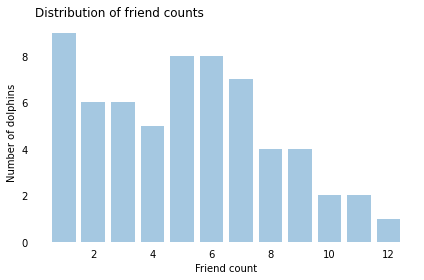

In [35]:
from empiricaldist import Pmf

pmf = Pmf.from_seq(unbiased, normalize=False)
pmf.bar(label="", alpha=0.4)
decorate(
    xlabel="Friend count",
    ylabel="Number of dolphins",
    title="Distribution of friend counts",
)

In [36]:
biased = resample_weighted(unbiased, unbiased)

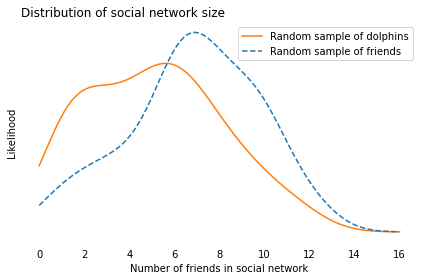

In [37]:
high = 16
xs = np.linspace(0, high, 101)
kdeplot(unbiased, xs, "Random sample of dolphins", color="C1")
kdeplot(biased, xs, "Random sample of friends", ls="--")

decorate(
    xlabel="Number of friends in social network",
    title="Distribution of social network size",
)

In [38]:
np.mean(biased), np.mean(unbiased)

(6.854838709677419, 5.129032258064516)

In [39]:
np.mean(biased > unbiased)

0.6290322580645161

## Finding Superspreaders



To quantify this effect, let's suppose that 70% of infected people don't infect anyone else, as in the Hong Kong study, and the other 30% infect between 1 and 15 other people, uniformly distributed. The average of this distribution is 2.4, which is a plausible value of $R$.

Now suppose we discover an infected patient, trace forward, and find
someone the patient infected. On average, we expect this person to
infect 2.4 other people.

In [40]:
import numpy as np

t1 = np.arange(1, 16)
t2 = [0] * 70
unbiased = np.concatenate([t1, t1, t2])
unbiased

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [41]:
np.mean(unbiased)

2.4

Here's the mean of the biased distribution.

In [42]:
biased = resample_weighted(unbiased, unbiased)
np.mean(biased)

10.29

In [43]:
np.mean(biased) / np.mean(unbiased)

4.2875

## Road Rage

In the following figure, the solid line shows the actual distribution of
speeds from the James Joyce Ramble, a 10K race in Massachusetts.


The original web page is not available, but we can get it from the Internet Archive


In [44]:

download("https://web.archive.org/web/20100429073703/http://coolrunning.com/results/10/ma/Apr25_27thAn_set1.shtml")

In [45]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(open("Apr25_27thAn_set1.shtml"), "html.parser")

In [46]:
import pandas as pd

speeds = pd.Series([], dtype=float)

table = soup.find("pre")
for line in table.text.split("\n"):
    t = line.split()
    if len(t) in [13, 14]:
        place, place_in_div, div, gun, net, pace = t[0:6]
        place = int(place)
        m, s = [int(x) for x in pace.split(":")]
        secs = m * 60 + s
        kph = 1.61 / secs * 60 * 60
        speeds[place] = kph

len(speeds)

1591

The following is the distribution a spectator would see if they watched all of the runners go by.
The dashed line shows the biased distribution that would be seen by a runner going 11 kilometers per hour (kph).

In [47]:
unbiased = speeds.values

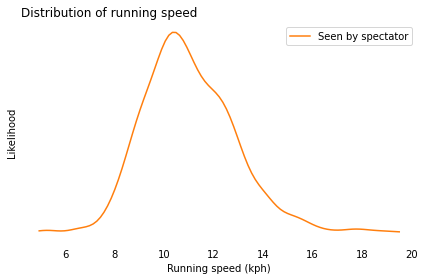

In [48]:
xs = np.linspace(speeds.min(), speeds.max(), 101)
kdeplot(unbiased, xs, "Seen by spectator", color="C1")

decorate(xlabel="Running speed (kph)", title="Distribution of running speed")

And here's the biased view seen be someone running 11 kph.

In [49]:
weights = np.abs(unbiased - 11)
biased = resample_weighted(unbiased, weights)

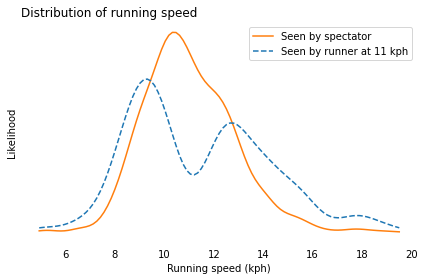

In [50]:
kdeplot(unbiased, xs, "Seen by spectator", color="C1")
kdeplot(biased, xs, "Seen by runner at 11 kph", ls="--")

decorate(xlabel="Running speed (kph)", title="Distribution of running speed")

In the actual distribution, there are a lot of runners near 11 kph, but if you run at that speed, you are unlikely to see them. 
As a result, the biased distribution has few runners near 11 kph and more at the extremes.
And it has two modes, one near 9 kph and one near 13 kph.
So that explains my oxygen-deprived confusion.

## Just Visiting

I downloaded data from the [U.S. Federal Bureau of Prisons](https://www.bop.gov/about/statistics/statistics_inmate_sentences.jsp) (BOP) in June 2019.
I archived the page so you can download it:


In [51]:
if not os.path.exists("../data/BOP Statistics_ Sentences Imposed.html"):
    !wget https://raw.githubusercontent.com/AllenDowney/InspectionParadox/master/BOP%20Statistics_%20Sentences%20Imposed.html

--2022-12-10 11:07:34--  https://raw.githubusercontent.com/AllenDowney/InspectionParadox/master/BOP%20Statistics_%20Sentences%20Imposed.html
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24902 (24K) [text/plain]
Saving to: ‘BOP Statistics_ Sentences Imposed.html.2’

BOP Statistics_ Sen 100%[===================>]  24.32K  --.-KB/s    in 0.002s  

2022-12-10 11:07:34 (10.6 MB/s) - ‘BOP Statistics_ Sentences Imposed.html.2’ saved [24902/24902]



In [52]:
tables = pd.read_html("BOP Statistics_ Sentences Imposed.html")
df = tables[0]
df

,Sentence,# of Inmates,% of Inmates
0,0 to 1 year*,5155,2.3 %
1,> 1 year to < 3 years**,18619,11.3%
2,3 years to < 5 years,17897,10.9%
3,5 years to < 10 years,41887,25.4%
4,10 years to < 15 years,34995,21.3%
5,15 years to < 20 years,18674,11.3%
6,20 years or more but < Life,22738,13.8%
7,Life,4600,2.8%


Here are the low and high sentences for each range.
I assume that the minimum sentence is about a week,
that sentences "less than life" are 40 years,
and that a life sentence is between 40 and 60 years.

In [53]:
sentences = [(0.02, 1), (1, 3), (3, 5), (5, 10), (10, 15), (15, 20), (20, 40), (40, 60)]

In [54]:
counts = df["# of Inmates"]

In [55]:
def generate_sample_continuous(sizes, counts):
    """Generate a sample from a distribution.

    sizes: sequence of (low, high) pairs
    counts: sequence of integers

    returns: NumPy array
    """
    t = []
    for (low, high), count in zip(sizes, counts):
        print(count, low, high)
        sample = np.random.uniform(low, high, count)
        t.extend(sample)
    return np.array(t)

In [56]:
biased = generate_sample_continuous(sentences, counts)

5155 0.02 1
18619 1 3
17897 3 5
41887 5 10
34995 10 15
18674 15 20
22738 20 40
4600 40 60


In [57]:
weights = 1 / (0.85 * np.array(biased))

In [58]:
unbiased = resample_weighted(biased, weights)


In the following figure, the dashed line shows the distribution of sentences as reported by the BOP.
The solid line shows the unbiased distribution I estimated.

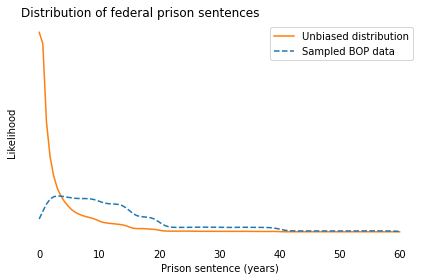

In [59]:
xs = np.linspace(0, 60, 101)
kdeplot(unbiased, xs, "Unbiased distribution", color="C1")
kdeplot(biased, xs, "Sampled BOP data", ls="--")

decorate(
    xlabel="Prison sentence (years)", title="Distribution of federal prison sentences"
)

In the BOP sample, sentences less than three years are underrepresented and longer sentences are overrepresented.

If the length of your stay is $y$, the chance of overlapping with a prisoner whose sentence is $x$ is proportional to $x + y$.
In the following figure, the dotted line shows what the resulting sample looks like when $y$ is 13 months.

In [60]:
x = 0.85 * unbiased
y = 13 / 12

weights = x + y

In [61]:
kerman = resample_weighted(unbiased, weights)

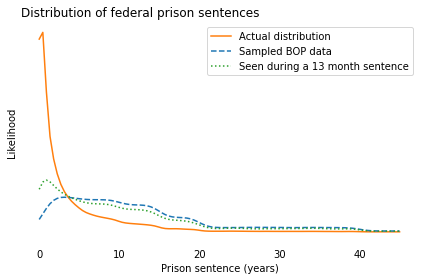

In [62]:
xs = np.linspace(0, 45, 101)
kdeplot(unbiased, xs, 'Actual distribution', color='C1')
kdeplot(biased, xs, 'Sampled BOP data', ls='--')
kdeplot(kerman, xs, 'Seen during a 13 month sentence', color='C2', ls=':')

decorate(xlabel='Prison sentence (years)',
         title='Distribution of federal prison sentences')


*   The mean of the actual distribution is 3.6 years; the mean of the biased distribution is almost 13 years, more than three times longer! To a 13-month observer, the mean is about 10 years, still much greater than the actual mean.

*   In the actual distribution, about 45% of prisoners have sentences less than a year. If you visit a prison once, fewer than 5% of the prisoners you see are short-timers. If you stay for 13 months, your estimate is better but still not accurate: about 15% of the prisoners you meet are short-timers.

In [63]:
# In the unbiased distribution, almost half of prisoners serve less than one year.

np.mean(unbiased < 1)

0.4573633518670434

In [64]:
np.mean(biased < 1)

0.0313250083553611

In [65]:
np.mean(kerman < 1)

0.14339014978883724

In [66]:
np.mean(unbiased)

3.5116851817207166

In [67]:
np.mean(biased)

12.770277541686598

In [68]:
np.mean(kerman)

10.196918727005256

## Recidivism

Rhodes, William, Gerald Gaes, Jeremy Luallen, Ryan Kling, Tom Rich, and Michael Shively. "Following incarceration, most released offenders never return to prison." Crime & Delinquency 62, no. 8 (2016): 1003-1025.


This 2016 paper in the journal *Crime & Delinquency* 
showed how the inspection paradox affects our estimates of recidivism, that is, the number of people released from prison who later return to prison.
Based on data from 17 states, collected between 2000 and 2012, the authors compute the number of admissions to prison in an event-based sample, on page 1015.

In [69]:
from empiricaldist import Pmf

ps = [0.51, 0.25, 0.13, 0.07, 0.03, 0.01]
ks = np.arange(1, len(ps) + 1)
pmf = Pmf(ps, ks)
pmf.sum()

1.0

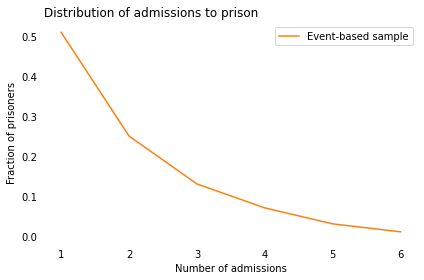

In [70]:
pmf.plot(color="C1", label="Event-based sample")

decorate(
    xlabel="Number of admissions",
    ylabel="Fraction of prisoners",
    title="Distribution of admissions to prison",
)

In [71]:
# fraction of recidivists in the event-based sample

1 - pmf[1]

0.49

In this sample, 51% of the prisoners served only one sentence; the other 49% were recidivists. We can use this data to simulate an individual-based sample.
In the following figure, the dashed line shows the result.

In [72]:
unbiased = pmf / ks
unbiased.normalize()

# fraction of recidivists in biased sample
1 - unbiased[1], unbiased[1]

(0.2750533049040512, 0.7249466950959488)

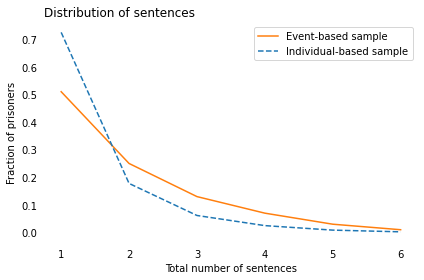

In [73]:
pmf.plot(color="C1", label="Event-based sample")
unbiased.plot(ls="--", label="Individual-based sample")

decorate(
    xlabel="Total number of sentences",
    ylabel="Fraction of prisoners",
    title="Distribution of sentences",
)

In [74]:
pmf.mean(), unbiased.mean()

(1.89, 1.421464108031272)

In the individual-based sample, most prisoners serve one sentence; only 28% are recidivists.
That's substantially lower than the recidivism rate in the event-based sample, which is 49%.

Probably Overthinking It

Copyright 2022 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).